In [1]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, plot_confusion_matrix, classification_report,confusion_matrix, f1_score, accuracy_score, roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier


In [2]:
df1 = pd.read_csv("../all_data_1.csv")
df2 = pd.read_csv("../all_data_2.csv")
df = pd.concat([df1,df2])
disordered = df.loc[df["label"]==1.0]
label_dis = disordered["label"]
disordered = disordered.drop(columns=["label", "sequence"])
ordered = df.loc[df["label"]==0.0]
label_ord = ordered["label"]
ordered = ordered.drop(columns=["label", "sequence"])

# 16316 disordered => 0.236 
# 240481 total ordered 
# 7704 => 3852 
#split ordered
xo_train, xo_test, yo_train, yo_test = train_test_split(disordered, label_dis, test_size=0.236)
#split disordered
xd_train, xd_test, yd_train, yd_test = train_test_split(ordered, label_ord, test_size=0.016)
#concatenate the two
train_features = pd.concat([xo_train, xd_train]).to_numpy().astype('float32')
train_labels = pd.concat([yo_train, yd_train]).to_numpy().astype('float32')

test_features = pd.concat([xo_test, xd_test]).to_numpy().astype('float32')
test_labels = pd.concat([yo_test, yd_test]).to_numpy().astype('float32')

print('Number of observations in the training data:', len(train_features))
print('Number of observations in the test data:',len(test_features))

Number of observations in the training data: 249098
Number of observations in the test data: 7699


*Random Forest classifier* 

In [3]:
clf = RandomForestClassifier(n_jobs=4, n_estimators=25, class_weight={0:1,1:20}, max_depth=25, random_state=0)
clf.fit(train_features, train_labels)
clf.predict(test_features)
clf.predict_proba(test_features)[0:10]

array([[4.78710394e-05, 9.99952129e-01],
       [8.80000000e-01, 1.20000000e-01],
       [2.89051860e-01, 7.10948140e-01],
       [6.07202683e-01, 3.92797317e-01],
       [2.96052021e-01, 7.03947979e-01],
       [6.44784037e-01, 3.55215963e-01],
       [2.78338320e-06, 9.99997217e-01],
       [8.51216656e-01, 1.48783344e-01],
       [8.10206379e-01, 1.89793621e-01],
       [8.05284126e-02, 9.19471587e-01]])

In [4]:
preds = clf.predict(test_features)

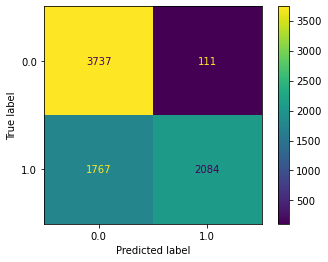

In [5]:
plot_confusion_matrix(clf, test_features, test_labels)

In [6]:
print(confusion_matrix(test_labels,preds))
print(classification_report(test_labels,preds))

[[3737  111]
 [1767 2084]]
              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      3848
         1.0       0.95      0.54      0.69      3851

    accuracy                           0.76      7699
   macro avg       0.81      0.76      0.74      7699
weighted avg       0.81      0.76      0.74      7699



In [7]:
from sklearn.tree import export_text
# trying to visualize the tree... not working
print(export_text(clf.estimators_[0], 
                  spacing=3, decimals=3,
                  feature_names= xo_train.columns))

ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [181]:
fig = plt.figure(figsize=(15, 10))
plot_tree(clf.estimators_[0], 
          feature_names=xo_train.columns,
          class_names=np.array(["order", "disorder"]), 
          filled=True, impurity=True, 
          rounded=True)

fig.savefig('zeroth_estimator.png')

Error in callback <function flush_figures at 0x7fb07d5bca60> (for post_execute):


KeyboardInterrupt: 

In [8]:
# find feature importance
list(zip(xo_train.columns, clf.feature_importances_))

[('seq_len', 0.04427245253543811),
 ('molecular_weight', 0.05214735326723102),
 ('hydrophobicity', 0.042763584280594485),
 ('instability_index', 0.046290974237619686),
 ('aromaticity', 0.0328073637829528),
 ('A %', 0.06290467273252041),
 ('C %', 0.03270666515812359),
 ('D %', 0.030744567321475187),
 ('E %', 0.034292570329352914),
 ('F %', 0.03210711509179493),
 ('G %', 0.0645386938707211),
 ('H %', 0.033512588620379175),
 ('I %', 0.0402635053501107),
 ('K %', 0.04940318663254156),
 ('L %', 0.028565839294015842),
 ('M %', 0.031523156422496375),
 ('N %', 0.06932927373998213),
 ('P %', 0.03914140768299843),
 ('Q %', 0.03128994315937075),
 ('R %', 0.033471708253441694),
 ('S %', 0.03664878785485586),
 ('T %', 0.032292277461250504),
 ('V %', 0.03763681172651977),
 ('W %', 0.03146000714953722),
 ('Y %', 0.029885494044675706)]

In [9]:
# balanced random forest 
brfc = BalancedRandomForestClassifier(n_estimators=100).fit(train_features,train_labels)
pred = brfc.predict(test_features)
print("F1 Score for Balanced Random Forest Classifier is ", f1_score(test_labels, pred))
print("Accuracy  Score for Balanced Random Forest Classifier is ", accuracy_score(test_labels,pred))
# print("roc_auc  Score for Balanced Random Forest Classifier is ", roc_auc_score(test_labels,pred)) => want to use class probabilities for this

F1 Score for Balanced Random Forest Classifier is  0.8096021947873802
Accuracy  Score for Balanced Random Forest Classifier is  0.819716846343681


In [10]:
print(confusion_matrix(test_labels,pred))
print(classification_report(test_labels,pred))

[[3360  488]
 [ 900 2951]]
              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83      3848
         1.0       0.86      0.77      0.81      3851

    accuracy                           0.82      7699
   macro avg       0.82      0.82      0.82      7699
weighted avg       0.82      0.82      0.82      7699



In [11]:
# find feature importance
list(zip(xo_train.columns, brfc.feature_importances_))

[('seq_len', 0.04476880735442397),
 ('molecular_weight', 0.057076037215813634),
 ('hydrophobicity', 0.04519806946363257),
 ('instability_index', 0.04613731085276426),
 ('aromaticity', 0.032150256957596456),
 ('A %', 0.06138882958088202),
 ('C %', 0.03345786267531828),
 ('D %', 0.032119851628111484),
 ('E %', 0.03417063001919243),
 ('F %', 0.03077494111641742),
 ('G %', 0.055402156235688775),
 ('H %', 0.032702555673132995),
 ('I %', 0.04815331929912503),
 ('K %', 0.04364764208268588),
 ('L %', 0.029716337479809986),
 ('M %', 0.03085449003888571),
 ('N %', 0.06750549665859569),
 ('P %', 0.03956125229025878),
 ('Q %', 0.030849340514772266),
 ('R %', 0.036188743780107765),
 ('S %', 0.0361178792063632),
 ('T %', 0.032860867787139134),
 ('V %', 0.036072738078152894),
 ('W %', 0.03086667007256318),
 ('Y %', 0.03225791393856617)]

In [13]:
predict_prob = brfc.predict_proba(test_features)
predict_prob2 = clf.predict_proba(test_features)
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_labels, predict_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(test_labels, predict_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_labels))]
p_fpr, p_tpr, _ = roc_curve(test_labels, random_probs, pos_label=1)

In [14]:
print("roc_auc Score for Balanced Random Forest Classifier is ", roc_auc_score(test_labels,predict_prob[:,1]))
print("roc_auc Score for Random Forest Classifier is ", roc_auc_score(test_labels,predict_prob2[:,1]))

roc_auc Score for Balanced Random Forest Classifier is  0.8983488574666191
roc_auc Score for Random Forest Classifier is  0.8777238314858412


In [15]:
print(test_labels)
print(predict_prob)
print(predict_prob[:,1])

[1. 1. 1. ... 0. 0. 0.]
[[0.         1.        ]
 [0.37916667 0.62083333]
 [0.071      0.929     ]
 ...
 [0.47166667 0.52833333]
 [0.76555556 0.23444444]
 [0.635      0.365     ]]
[1.         0.62083333 0.929      ... 0.52833333 0.23444444 0.365     ]


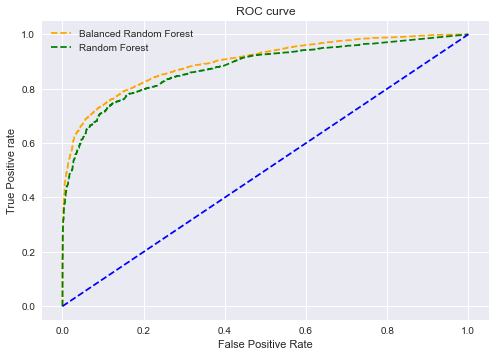

In [16]:
# matplotlib
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Balanced Random Forest')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=600)
plt.show()